In [1]:
## This notebook is a weekend dump for me just trying out and looking for the best techniques to sample data to prevent
## 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/Dead-Reackoning-Processed.csv')

In [10]:
x = df['location-lat']
y = df['location-long']

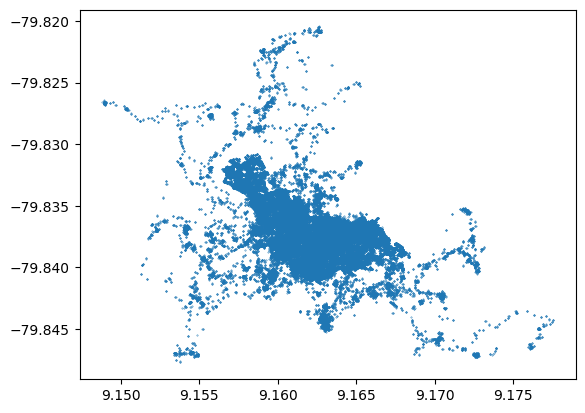

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x, y, s=0.1)

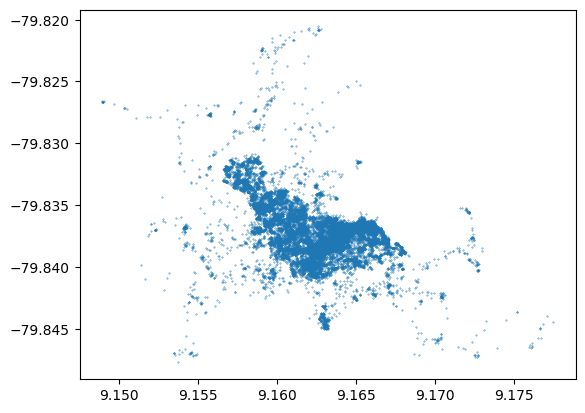

In [22]:
df2 = pd.read_csv('data/Dead-Reackon-Sample.csv')
x = df2['location-lat']
y = df2['location-long']
plt.scatter(x, y, s=0.1)

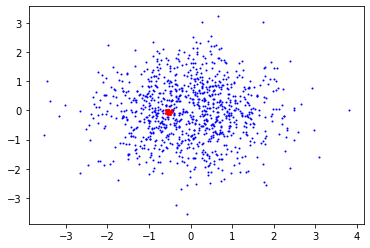

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Create some sample data
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)

# Stack x and y into a single array
data = np.column_stack((x, y))

# Perform density-based sampling using DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
labels = dbscan.fit_predict(data)

# Plot the sampled data
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], s=5, color='red')
plt.scatter(data[labels == -1, 0], data[labels == -1, 1], s=1, color='blue')
plt.show()

In [4]:
!python --version

Python 2.7.18


In [2]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
df = pd.read_csv('data/Dead-Reackon-Sample.csv')

X = df[['location-lat', 'location-long']]

# Use DBSCAN to cluster the data
dbscan = DBSCAN(eps=0.1, min_samples=10)
labels = dbscan.fit_predict(X)

# Compute the number of points in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Compute the number of points to sample from each cluster
n_samples = (0.2 * len(X)) / len(unique_labels)
n_samples_per_label = np.ceil(counts * n_samples).astype(int)

# Sample the data from each cluster
new_X = []
for i, label in enumerate(unique_labels):
    if label == -1:
        continue
    cluster_points = X[labels == label]
    sampled_points = cluster_points[np.random.choice(len(cluster_points), n_samples_per_label[i], replace=False)]
    new_X.append(sampled_points)
new_X = np.concatenate(new_X, axis=0)

# Plot the original and subsampled data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].scatter(X[:, 0], X[:, 1], s=5)
ax[0].set_title("Original Data")
ax[1].scatter(new_X[:, 0], new_X[:, 1], s=5)
ax[1].set_title("Subsampled Data")
plt.show()


In [9]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
# Generate some random data

df = pd.read_csv('data/Dead-Reackoning-Processed.csv')
X = df[['location-lat', 'location-long']]
# Use DBSCAN to cluster the data
dbscan = DBSCAN(eps=1e-5, min_samples=1000)
labels = dbscan.fit_predict(X)


In [4]:

# Compute the number of points in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Compute the number of points to sample from each cluster
n_samples = (0.2 * len(X)) / len(unique_labels)
n_samples_per_label = np.ceil(counts * n_samples).astype(int)

# Sample the data from each cluster
new_X = []
for i, label in enumerate(unique_labels):
    if label == -1:
        continue
    cluster_points = X[labels == label]
    sampled_points = cluster_points[np.random.choice(len(cluster_points), n_samples_per_label[i], replace=False)]
    new_X.append(sampled_points)
new_X = np.concatenate(new_X, axis=0)

# Plot the original and subsampled data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].scatter(X[:, 0], X[:, 1], s=5)
ax[0].set_title("Original Data")
ax[1].scatter(new_X[:, 0], new_X[:, 1], s=5)
ax[1].set_title("Subsampled Data")
plt.show()


NameError: name 'sampled_points' is not defined

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from multiprocessing import Pool, cpu_count
df = pd.read_csv('data/Dead-Reackoning-Processed.csv')
X = df[['location-lat', 'location-long']]

# set the subsampling percentage
subsample_pct = 0.15

# calculate the number of points to subsample
n_subsample = int(subsample_pct * X.shape[0])

# set the number of clusters
n_clusters = int(np.sqrt(n_subsample))

# define the clustering function
def cluster_chunk(chunk):
    km = KMeans(n_clusters=n_clusters)
    km.fit(chunk)
    centroids = km.cluster_centers_
    distances = km.transform(chunk)
    labels = np.argmin(distances, axis=1)
    return centroids, labels

# split the data into chunks
n_chunks = cpu_count()
chunk_size = int(np.ceil(X.shape[0] / n_chunks))
chunks = [X[i:i+chunk_size] for i in range(0, X.shape[0], chunk_size)]

# create a pool of worker processes
pool = Pool(processes=n_chunks)

# apply the clustering function to each chunk in parallel
results = pool.map(cluster_chunk, chunks)

# concatenate the centroids and labels from each chunk
centroids = np.vstack([result[0] for result in results])
labels = np.concatenate([result[1] for result in results])

# subsample the points with the most common labels
unique_labels, counts = np.unique(labels, return_counts=True)
subsample_labels = unique_labels[np.argsort(counts)[-n_subsample:]]
subsample_mask = np.isin(labels, subsample_labels)

# select the subsampled points from the original data
X_subsampled = X[subsample_mask]

# close the pool of worker processes
pool.close()
pool.join()


Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'cluster_chunk' on <module '__main__' (built-in)>
Process SpawnPoolWorker-6:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.

KeyboardInterrupt: 

In [6]:
pool.close()
pool.join()

Process SpawnPoolWorker-20:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-22:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with s

KeyboardInterrupt: 

n3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, 